In [1]:
!pip install optuna

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,gamma=1):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = gamma # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

In [4]:
from plots import plot_gridworld

In [5]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [6]:
import optuna

In [7]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_0, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 18:39:11,390] A new study created in memory with name: no-name-96ce6cde-bf23-4ec2-8fd6-623a65a5c372


Trial 0: Alpha = 0.18134863080677305, Epsilon = 0.326400363265526,Gamma=0.637634262091752
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:39:51,524] Trial 0 finished with value: 399859.30000000005 and parameters: {'alpha': 0.18134863080677305, 'epsilon': 0.326400363265526, 'gamma': 0.637634262091752}. Best is trial 0 with value: 399859.30000000005.


Trial 1: Alpha = 0.3756719727461784, Epsilon = 0.20382601868473216,Gamma=0.8720935087367749
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:40:06,684] Trial 1 finished with value: 87271.20000000001 and parameters: {'alpha': 0.3756719727461784, 'epsilon': 0.20382601868473216, 'gamma': 0.8720935087367749}. Best is trial 1 with value: 87271.20000000001.


Trial 2: Alpha = 0.10744776118630942, Epsilon = 0.44994383139554306,Gamma=0.7049965023263235
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:40:47,494] Trial 2 finished with value: 417255.3 and parameters: {'alpha': 0.10744776118630942, 'epsilon': 0.44994383139554306, 'gamma': 0.7049965023263235}. Best is trial 1 with value: 87271.20000000001.


Trial 3: Alpha = 0.27295070397060184, Epsilon = 0.4506564090316292,Gamma=0.8445121516960511
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 18:41:07,854] Trial 3 finished with value: 199224.4 and parameters: {'alpha': 0.27295070397060184, 'epsilon': 0.4506564090316292, 'gamma': 0.8445121516960511}. Best is trial 1 with value: 87271.20000000001.


Running episode 4000.
Trial 4: Alpha = 0.24840770232109033, Epsilon = 0.1300284455206653,Gamma=0.5808319057615416
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:41:40,256] Trial 4 finished with value: 314069.5 and parameters: {'alpha': 0.24840770232109033, 'epsilon': 0.1300284455206653, 'gamma': 0.5808319057615416}. Best is trial 1 with value: 87271.20000000001.


Trial 5: Alpha = 0.4350341967830978, Epsilon = 0.17057008341090488,Gamma=0.8522752094157909
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:41:54,586] Trial 5 finished with value: 82529.4 and parameters: {'alpha': 0.4350341967830978, 'epsilon': 0.17057008341090488, 'gamma': 0.8522752094157909}. Best is trial 5 with value: 82529.4.


Trial 6: Alpha = 0.20982113453535933, Epsilon = 0.3068226604060883,Gamma=0.8625602328852565
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:42:10,944] Trial 6 finished with value: 120951.4 and parameters: {'alpha': 0.20982113453535933, 'epsilon': 0.3068226604060883, 'gamma': 0.8625602328852565}. Best is trial 5 with value: 82529.4.


Trial 7: Alpha = 0.1699637304868382, Epsilon = 0.20749724138092931,Gamma=0.7944447278473199
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:42:25,594] Trial 7 finished with value: 95098.0 and parameters: {'alpha': 0.1699637304868382, 'epsilon': 0.20749724138092931, 'gamma': 0.7944447278473199}. Best is trial 5 with value: 82529.4.


Trial 8: Alpha = 0.14562600097794537, Epsilon = 0.4923317957068446,Gamma=0.7222456654570568
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:43:09,815] Trial 8 finished with value: 452008.8 and parameters: {'alpha': 0.14562600097794537, 'epsilon': 0.4923317957068446, 'gamma': 0.7222456654570568}. Best is trial 5 with value: 82529.4.


Trial 9: Alpha = 0.41815072655399593, Epsilon = 0.48697958276450937,Gamma=0.8007060863450814
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:43:41,324] Trial 9 finished with value: 315473.5 and parameters: {'alpha': 0.41815072655399593, 'epsilon': 0.48697958276450937, 'gamma': 0.8007060863450814}. Best is trial 5 with value: 82529.4.


Trial 10: Alpha = 0.47073658134501617, Epsilon = 0.10886017026125681,Gamma=0.9801886743762447
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:43:54,481] Trial 10 finished with value: 80697.1 and parameters: {'alpha': 0.47073658134501617, 'epsilon': 0.10886017026125681, 'gamma': 0.9801886743762447}. Best is trial 10 with value: 80697.1.


Trial 11: Alpha = 0.4689505253370333, Epsilon = 0.11079831461205329,Gamma=0.9889735636649206
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:44:09,287] Trial 11 finished with value: 82698.6 and parameters: {'alpha': 0.4689505253370333, 'epsilon': 0.11079831461205329, 'gamma': 0.9889735636649206}. Best is trial 10 with value: 80697.1.


Trial 12: Alpha = 0.3266962725257476, Epsilon = 0.14885275077113566,Gamma=0.9850981844770608
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:44:23,034] Trial 12 finished with value: 81259.3 and parameters: {'alpha': 0.3266962725257476, 'epsilon': 0.14885275077113566, 'gamma': 0.9850981844770608}. Best is trial 10 with value: 80697.1.


Trial 13: Alpha = 0.35120348640036647, Epsilon = 0.15077508486169186,Gamma=0.99803241053088
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 18:44:41,231] Trial 13 finished with value: 108475.0 and parameters: {'alpha': 0.35120348640036647, 'epsilon': 0.15077508486169186, 'gamma': 0.99803241053088}. Best is trial 10 with value: 80697.1.


Running episode 4000.
Trial 14: Alpha = 0.31141276514906985, Epsilon = 0.1040452530499587,Gamma=0.9514730280808217
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.


[I 2024-02-27 18:44:54,132] Trial 14 finished with value: 63360.5 and parameters: {'alpha': 0.31141276514906985, 'epsilon': 0.1040452530499587, 'gamma': 0.9514730280808217}. Best is trial 14 with value: 63360.5.


Running episode 2000.
Running episode 3000.
Running episode 4000.
Trial 15: Alpha = 0.49954452214891215, Epsilon = 0.10028199479926765,Gamma=0.941272064935102
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:45:07,786] Trial 15 finished with value: 66660.7 and parameters: {'alpha': 0.49954452214891215, 'epsilon': 0.10028199479926765, 'gamma': 0.941272064935102}. Best is trial 14 with value: 63360.5.


Trial 16: Alpha = 0.2751883689609159, Epsilon = 0.10354868684495101,Gamma=0.5269357004283984
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:45:48,521] Trial 16 finished with value: 378080.0 and parameters: {'alpha': 0.2751883689609159, 'epsilon': 0.10354868684495101, 'gamma': 0.5269357004283984}. Best is trial 14 with value: 63360.5.


Trial 17: Alpha = 0.3178113001612628, Epsilon = 0.12482238268050096,Gamma=0.9054199250740437
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:46:01,373] Trial 17 finished with value: 69102.0 and parameters: {'alpha': 0.3178113001612628, 'epsilon': 0.12482238268050096, 'gamma': 0.9054199250740437}. Best is trial 14 with value: 63360.5.


Trial 18: Alpha = 0.3823536165458381, Epsilon = 0.29238854635501477,Gamma=0.7382496836100855
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:46:30,736] Trial 18 finished with value: 280545.1 and parameters: {'alpha': 0.3823536165458381, 'epsilon': 0.29238854635501477, 'gamma': 0.7382496836100855}. Best is trial 14 with value: 63360.5.


Trial 19: Alpha = 0.29453450071714443, Epsilon = 0.2465581310998686,Gamma=0.9230520549688881
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 18:46:45,685] Trial 19 finished with value: 100488.5 and parameters: {'alpha': 0.29453450071714443, 'epsilon': 0.2465581310998686, 'gamma': 0.9230520549688881}. Best is trial 14 with value: 63360.5.


Running episode 4000.


In [8]:

best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.31141276514906985
Best Epsilon: 0.1040452530499587
Best gamma: 0.9514730280808217


In [9]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [10]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


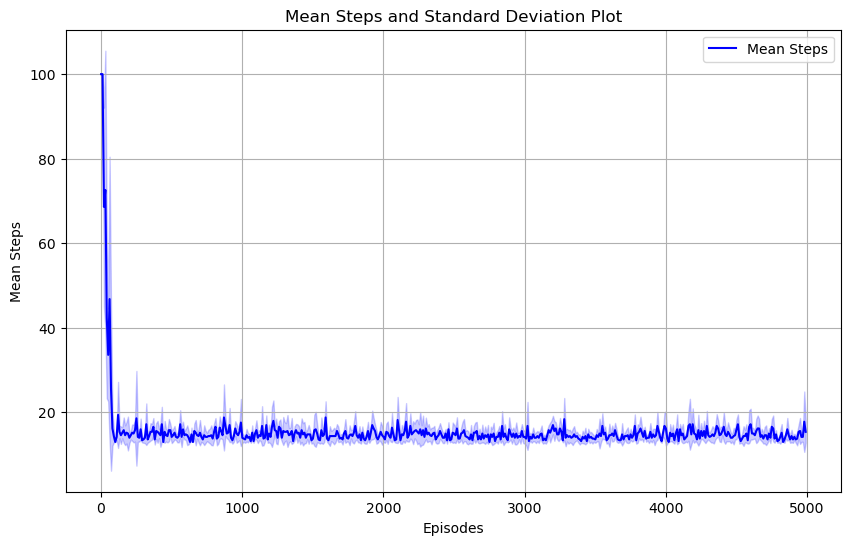

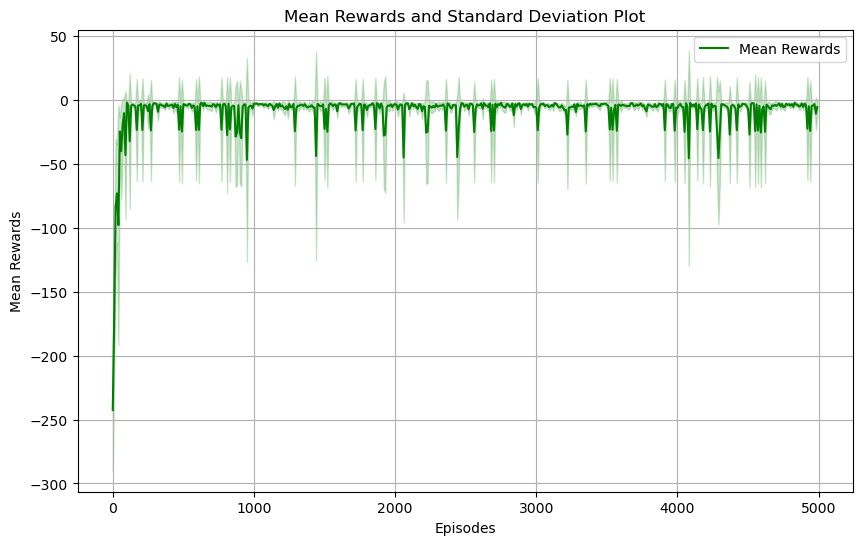

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


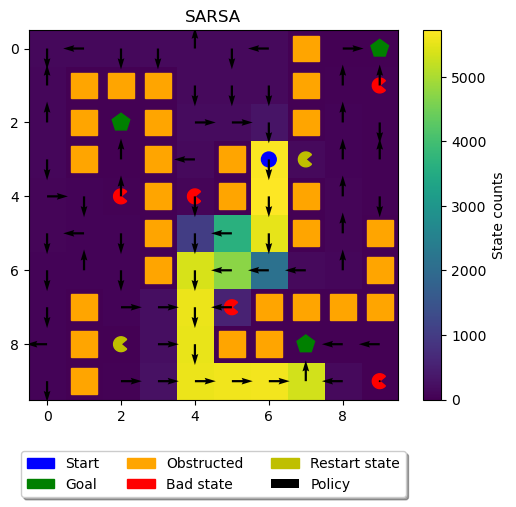

In [12]:
plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

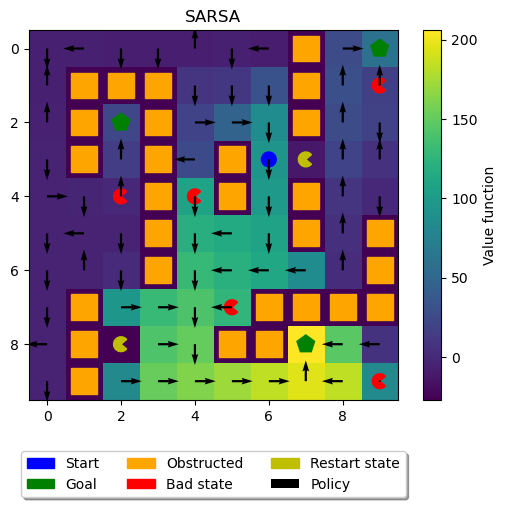

In [13]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 18:47:00,223] A new study created in memory with name: no-name-f358aefb-d3fb-4115-b0d2-4be755f0f0d6


Trial 0: Alpha = 0.15061758091208297, Temperature = 0.17300479309436367,Gamma=0.583676111078182
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:48:18,181] Trial 0 finished with value: 285603.19999999995 and parameters: {'alpha': 0.15061758091208297, 'temperature': 0.17300479309436367, 'gamma': 0.583676111078182}. Best is trial 0 with value: 285603.19999999995.


Trial 1: Alpha = 0.4403436254795352, Temperature = 0.5878813159250733,Gamma=0.9539216709092496
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:48:39,077] Trial 1 finished with value: 41686.2 and parameters: {'alpha': 0.4403436254795352, 'temperature': 0.5878813159250733, 'gamma': 0.9539216709092496}. Best is trial 1 with value: 41686.2.


Trial 2: Alpha = 0.19669175274911602, Temperature = 0.15527601862786813,Gamma=0.6096326155451315
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:49:47,923] Trial 2 finished with value: 242177.4 and parameters: {'alpha': 0.19669175274911602, 'temperature': 0.15527601862786813, 'gamma': 0.6096326155451315}. Best is trial 1 with value: 41686.2.


Trial 3: Alpha = 0.4821381777438545, Temperature = 0.165285294829794,Gamma=0.9952061579677286
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:50:08,014] Trial 3 finished with value: 48322.3 and parameters: {'alpha': 0.4821381777438545, 'temperature': 0.165285294829794, 'gamma': 0.9952061579677286}. Best is trial 1 with value: 41686.2.


Trial 4: Alpha = 0.32897200565471457, Temperature = 0.6043286537576222,Gamma=0.5059605272772179
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:52:00,184] Trial 4 finished with value: 410223.8 and parameters: {'alpha': 0.32897200565471457, 'temperature': 0.6043286537576222, 'gamma': 0.5059605272772179}. Best is trial 1 with value: 41686.2.


Trial 5: Alpha = 0.12661297292517779, Temperature = 0.20468829702313007,Gamma=0.71419428939898
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:52:27,974] Trial 5 finished with value: 64663.1 and parameters: {'alpha': 0.12661297292517779, 'temperature': 0.20468829702313007, 'gamma': 0.71419428939898}. Best is trial 1 with value: 41686.2.


Trial 6: Alpha = 0.1454869846911539, Temperature = 0.8921534900662995,Gamma=0.7569066220812968
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:53:10,099] Trial 6 finished with value: 128635.3 and parameters: {'alpha': 0.1454869846911539, 'temperature': 0.8921534900662995, 'gamma': 0.7569066220812968}. Best is trial 1 with value: 41686.2.


Trial 7: Alpha = 0.29282085729301005, Temperature = 0.11242729406818397,Gamma=0.6280992229874249
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:53:57,269] Trial 7 finished with value: 154634.4 and parameters: {'alpha': 0.29282085729301005, 'temperature': 0.11242729406818397, 'gamma': 0.6280992229874249}. Best is trial 1 with value: 41686.2.


Trial 8: Alpha = 0.22507755977376348, Temperature = 0.11111948425228799,Gamma=0.9231254041859961
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:54:19,640] Trial 8 finished with value: 43228.6 and parameters: {'alpha': 0.22507755977376348, 'temperature': 0.11111948425228799, 'gamma': 0.9231254041859961}. Best is trial 1 with value: 41686.2.


Trial 9: Alpha = 0.18562252749163305, Temperature = 0.3462848473677506,Gamma=0.6016738107827678
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:55:44,109] Trial 9 finished with value: 313955.6 and parameters: {'alpha': 0.18562252749163305, 'temperature': 0.3462848473677506, 'gamma': 0.6016738107827678}. Best is trial 1 with value: 41686.2.


Trial 10: Alpha = 0.47943128602437485, Temperature = 0.4433036721960496,Gamma=0.8328080459936273
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:56:05,704] Trial 10 finished with value: 44588.8 and parameters: {'alpha': 0.47943128602437485, 'temperature': 0.4433036721960496, 'gamma': 0.8328080459936273}. Best is trial 1 with value: 41686.2.


Trial 11: Alpha = 0.10017434120610105, Temperature = 0.677047820826127,Gamma=0.9924097716341943
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:56:30,016] Trial 11 finished with value: 53066.899999999994 and parameters: {'alpha': 0.10017434120610105, 'temperature': 0.677047820826127, 'gamma': 0.9924097716341943}. Best is trial 1 with value: 41686.2.


Trial 12: Alpha = 0.2943748675740462, Temperature = 0.28974982993583126,Gamma=0.8649344593131971
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:56:52,249] Trial 12 finished with value: 43185.0 and parameters: {'alpha': 0.2943748675740462, 'temperature': 0.28974982993583126, 'gamma': 0.8649344593131971}. Best is trial 1 with value: 41686.2.


Trial 13: Alpha = 0.34838882559793327, Temperature = 0.27329194523418543,Gamma=0.8489859895211954
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:57:13,995] Trial 13 finished with value: 45218.0 and parameters: {'alpha': 0.34838882559793327, 'temperature': 0.27329194523418543, 'gamma': 0.8489859895211954}. Best is trial 1 with value: 41686.2.


Trial 14: Alpha = 0.3839548420229282, Temperature = 0.442031645238674,Gamma=0.8645203249336745
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:57:35,289] Trial 14 finished with value: 45172.4 and parameters: {'alpha': 0.3839548420229282, 'temperature': 0.442031645238674, 'gamma': 0.8645203249336745}. Best is trial 1 with value: 41686.2.


Trial 15: Alpha = 0.27815890440827407, Temperature = 0.2730071003185735,Gamma=0.7932722625530797
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:57:57,312] Trial 15 finished with value: 44391.8 and parameters: {'alpha': 0.27815890440827407, 'temperature': 0.2730071003185735, 'gamma': 0.7932722625530797}. Best is trial 1 with value: 41686.2.


Trial 16: Alpha = 0.39867980487803667, Temperature = 0.9698885185511659,Gamma=0.8957403743289711
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:58:19,330] Trial 16 finished with value: 43527.0 and parameters: {'alpha': 0.39867980487803667, 'temperature': 0.9698885185511659, 'gamma': 0.8957403743289711}. Best is trial 1 with value: 41686.2.


Trial 17: Alpha = 0.24916565002037316, Temperature = 0.4071302134146794,Gamma=0.9372198788857816
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:58:40,257] Trial 17 finished with value: 46472.5 and parameters: {'alpha': 0.24916565002037316, 'temperature': 0.4071302134146794, 'gamma': 0.9372198788857816}. Best is trial 1 with value: 41686.2.


Trial 18: Alpha = 0.42138311136852924, Temperature = 0.5811940129932978,Gamma=0.7664518580656979
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:59:05,803] Trial 18 finished with value: 58789.299999999996 and parameters: {'alpha': 0.42138311136852924, 'temperature': 0.5811940129932978, 'gamma': 0.7664518580656979}. Best is trial 1 with value: 41686.2.


Trial 19: Alpha = 0.3055631641379491, Temperature = 0.2371015535287464,Gamma=0.6765526493952395
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:59:48,394] Trial 19 finished with value: 135668.6 and parameters: {'alpha': 0.3055631641379491, 'temperature': 0.2371015535287464, 'gamma': 0.6765526493952395}. Best is trial 1 with value: 41686.2.


In [15]:

best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.4403436254795352
Best temp: 0.5878813159250733
Best gamma: 0.9539216709092496


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


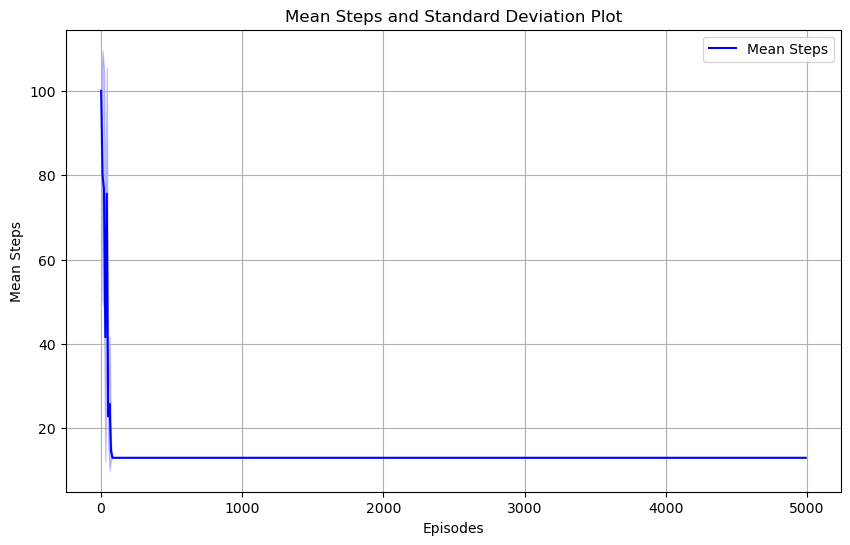

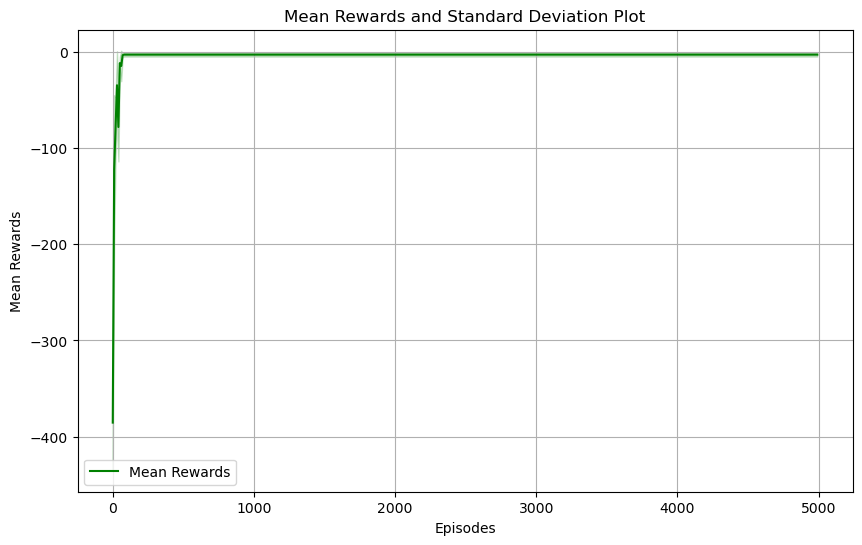

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


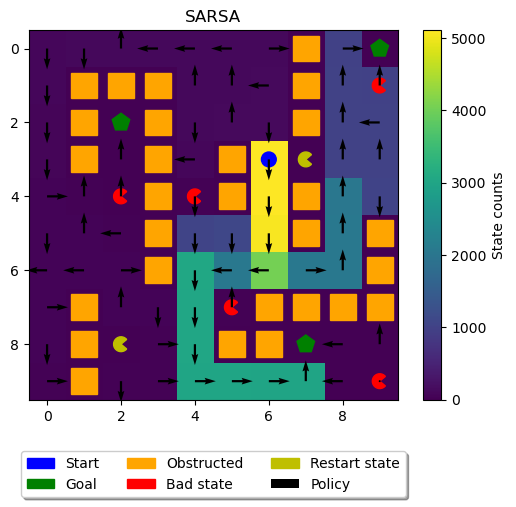

In [19]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

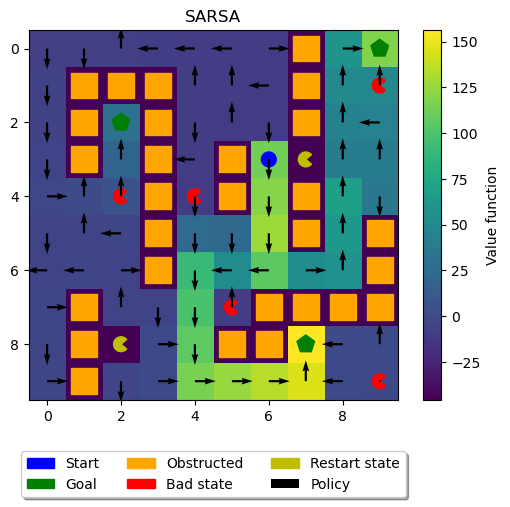

In [20]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [21]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [22]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_1, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials



[I 2024-02-27 19:00:09,729] A new study created in memory with name: no-name-7340299c-9e26-4908-9e41-e5eea9941233


Trial 0: Alpha = 0.10273682726603292, Epsilon = 0.19505501835006983,Gamma=0.9108862478108756
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 19:00:20,322] Trial 0 finished with value: 82892.0 and parameters: {'alpha': 0.10273682726603292, 'epsilon': 0.19505501835006983, 'gamma': 0.9108862478108756}. Best is trial 0 with value: 82892.0.


Running episode 4000.
Trial 1: Alpha = 0.1967291838315877, Epsilon = 0.451185767908382,Gamma=0.8596199542706706
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:00:36,074] Trial 1 finished with value: 137567.2 and parameters: {'alpha': 0.1967291838315877, 'epsilon': 0.451185767908382, 'gamma': 0.8596199542706706}. Best is trial 0 with value: 82892.0.


Trial 2: Alpha = 0.22702861601763685, Epsilon = 0.24375772787033487,Gamma=0.8373770516023241
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:00:48,669] Trial 2 finished with value: 103907.5 and parameters: {'alpha': 0.22702861601763685, 'epsilon': 0.24375772787033487, 'gamma': 0.8373770516023241}. Best is trial 0 with value: 82892.0.


Running episode 3000.
Running episode 4000.
Trial 3: Alpha = 0.4780097396036085, Epsilon = 0.3965672882745992,Gamma=0.9027880748485192
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:01:10,130] Trial 3 finished with value: 189719.0 and parameters: {'alpha': 0.4780097396036085, 'epsilon': 0.3965672882745992, 'gamma': 0.9027880748485192}. Best is trial 0 with value: 82892.0.


Trial 4: Alpha = 0.3623848977177682, Epsilon = 0.36371630451829995,Gamma=0.8000396696243132
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:01:27,521] Trial 4 finished with value: 152489.7 and parameters: {'alpha': 0.3623848977177682, 'epsilon': 0.36371630451829995, 'gamma': 0.8000396696243132}. Best is trial 0 with value: 82892.0.


Trial 5: Alpha = 0.25818109551591356, Epsilon = 0.22339493528325646,Gamma=0.9983361918145228
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:01:40,641] Trial 5 finished with value: 109143.7 and parameters: {'alpha': 0.25818109551591356, 'epsilon': 0.22339493528325646, 'gamma': 0.9983361918145228}. Best is trial 0 with value: 82892.0.


Trial 6: Alpha = 0.11272829333080468, Epsilon = 0.2581320848137205,Gamma=0.8865853033342246
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.


[I 2024-02-27 19:01:52,100] Trial 6 finished with value: 91868.79999999999 and parameters: {'alpha': 0.11272829333080468, 'epsilon': 0.2581320848137205, 'gamma': 0.8865853033342246}. Best is trial 0 with value: 82892.0.


Running episode 2000.
Running episode 3000.
Running episode 4000.
Trial 7: Alpha = 0.11189011049308126, Epsilon = 0.2057813935802658,Gamma=0.97278395607076
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:02:02,847] Trial 7 finished with value: 84315.2 and parameters: {'alpha': 0.11189011049308126, 'epsilon': 0.2057813935802658, 'gamma': 0.97278395607076}. Best is trial 0 with value: 82892.0.


Trial 8: Alpha = 0.44777422636698133, Epsilon = 0.4255743733760466,Gamma=0.8610347601835934
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:02:23,486] Trial 8 finished with value: 181628.0 and parameters: {'alpha': 0.44777422636698133, 'epsilon': 0.4255743733760466, 'gamma': 0.8610347601835934}. Best is trial 0 with value: 82892.0.


Trial 9: Alpha = 0.1790104814641415, Epsilon = 0.34108510209876497,Gamma=0.9950057412982521
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:02:36,573] Trial 9 finished with value: 108939.5 and parameters: {'alpha': 0.1790104814641415, 'epsilon': 0.34108510209876497, 'gamma': 0.9950057412982521}. Best is trial 0 with value: 82892.0.


Running episode 3000.
Running episode 4000.
Trial 10: Alpha = 0.14584101127412918, Epsilon = 0.11830617484665892,Gamma=0.9308553348845502
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:02:46,073] Trial 10 finished with value: 70806.3 and parameters: {'alpha': 0.14584101127412918, 'epsilon': 0.11830617484665892, 'gamma': 0.9308553348845502}. Best is trial 10 with value: 70806.3.


Running episode 3000.
Running episode 4000.
Trial 11: Alpha = 0.1480342540115949, Epsilon = 0.11005136474255632,Gamma=0.9389002078339165
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:02:55,401] Trial 11 finished with value: 70067.9 and parameters: {'alpha': 0.1480342540115949, 'epsilon': 0.11005136474255632, 'gamma': 0.9389002078339165}. Best is trial 11 with value: 70067.9.


Trial 12: Alpha = 0.1472944756735409, Epsilon = 0.10130677832940661,Gamma=0.9382826481665543
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 19:03:04,729] Trial 12 finished with value: 68840.9 and parameters: {'alpha': 0.1472944756735409, 'epsilon': 0.10130677832940661, 'gamma': 0.9382826481665543}. Best is trial 12 with value: 68840.9.


Running episode 4000.
Trial 13: Alpha = 0.14598275475586578, Epsilon = 0.10996833565336994,Gamma=0.9494854927119137
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:03:14,348] Trial 13 finished with value: 69874.1 and parameters: {'alpha': 0.14598275475586578, 'epsilon': 0.10996833565336994, 'gamma': 0.9494854927119137}. Best is trial 12 with value: 68840.9.


Running episode 3000.
Running episode 4000.
Trial 14: Alpha = 0.15059355699415047, Epsilon = 0.16230278726481775,Gamma=0.9532066922679155
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:03:24,744] Trial 14 finished with value: 78971.29999999999 and parameters: {'alpha': 0.15059355699415047, 'epsilon': 0.16230278726481775, 'gamma': 0.9532066922679155}. Best is trial 12 with value: 68840.9.


Trial 15: Alpha = 0.2657019186414735, Epsilon = 0.1398848858227923,Gamma=0.952032523132621
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:03:39,019] Trial 15 finished with value: 104224.20000000001 and parameters: {'alpha': 0.2657019186414735, 'epsilon': 0.1398848858227923, 'gamma': 0.952032523132621}. Best is trial 12 with value: 68840.9.


Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Trial 16: Alpha = 0.1375484453055661, Epsilon = 0.10330282104365271,Gamma=0.9210756777661555
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:03:48,222] Trial 16 finished with value: 69121.6 and parameters: {'alpha': 0.1375484453055661, 'epsilon': 0.10330282104365271, 'gamma': 0.9210756777661555}. Best is trial 12 with value: 68840.9.


Trial 17: Alpha = 0.181447878660868, Epsilon = 0.14288595423737382,Gamma=0.9194530239728905
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:03:58,525] Trial 17 finished with value: 80033.8 and parameters: {'alpha': 0.181447878660868, 'epsilon': 0.14288595423737382, 'gamma': 0.9194530239728905}. Best is trial 12 with value: 68840.9.


Running episode 3000.
Running episode 4000.
Trial 18: Alpha = 0.12424809238080135, Epsilon = 0.1350611148773712,Gamma=0.8833986158721168
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:04:08,186] Trial 18 finished with value: 73634.9 and parameters: {'alpha': 0.12424809238080135, 'epsilon': 0.1350611148773712, 'gamma': 0.8833986158721168}. Best is trial 12 with value: 68840.9.


Trial 19: Alpha = 0.1274529231307205, Epsilon = 0.16589673774741617,Gamma=0.8663083473697842
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 19:04:18,233] Trial 19 finished with value: 77817.20000000001 and parameters: {'alpha': 0.1274529231307205, 'epsilon': 0.16589673774741617, 'gamma': 0.8663083473697842}. Best is trial 12 with value: 68840.9.


Running episode 3000.
Running episode 4000.


In [23]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)




Best Hyperparameters:
Best Alpha: 0.1472944756735409
Best Epsilon: 0.10130677832940661
Best gamma: 0.9382826481665543


In [24]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [25]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


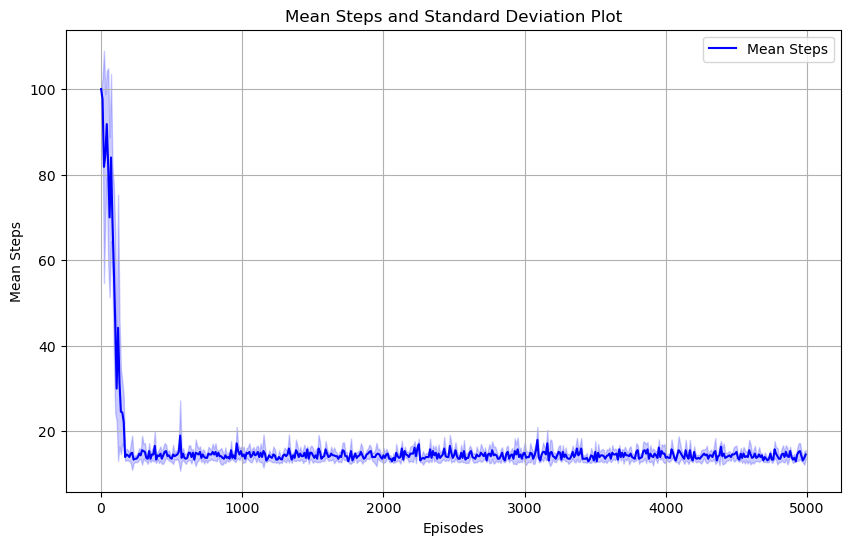

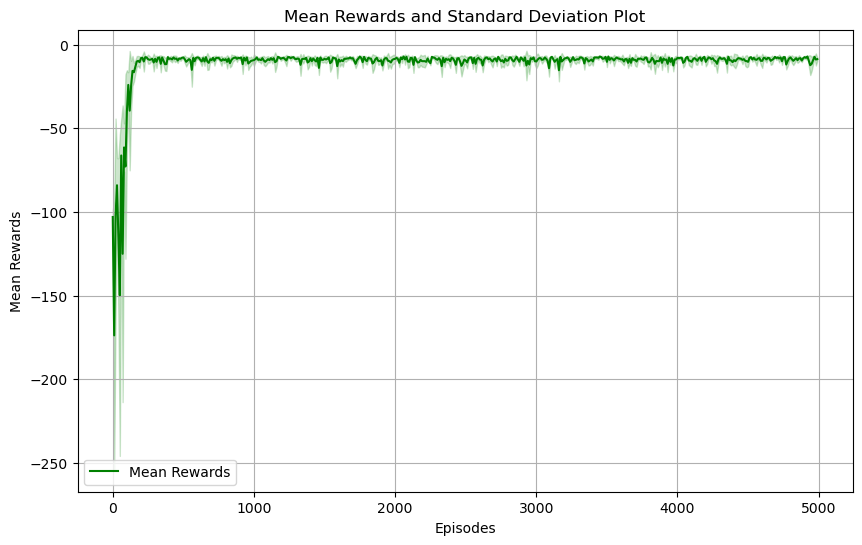

In [26]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


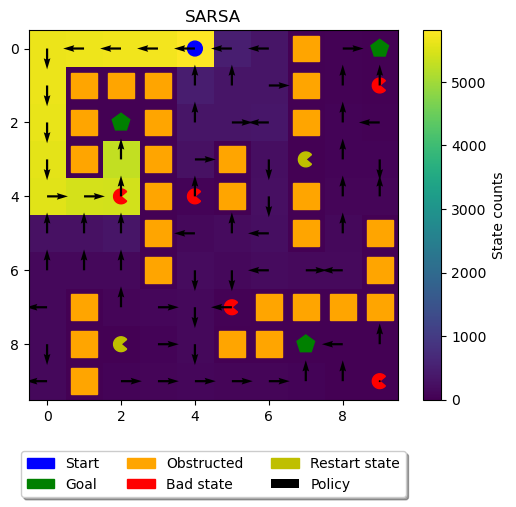

In [27]:


plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


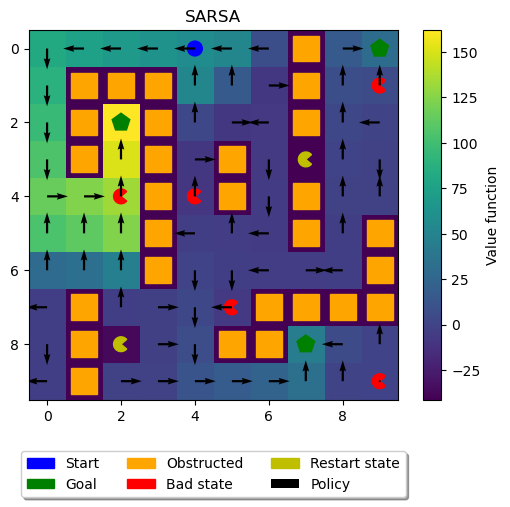

In [28]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")


In [29]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials


[I 2024-02-27 19:04:28,239] A new study created in memory with name: no-name-3f2be4bf-efe1-49d8-b1ed-fa04cd9a6bdf


Trial 0: Alpha = 0.1232197677810043, Temperature = 0.23974759018917205,Gamma=0.9768042986936486
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:04:48,334] Trial 0 finished with value: 61566.5 and parameters: {'alpha': 0.1232197677810043, 'temperature': 0.23974759018917205, 'gamma': 0.9768042986936486}. Best is trial 0 with value: 61566.5.


Trial 1: Alpha = 0.10461395362325299, Temperature = 0.8486974386329523,Gamma=0.8577532074265547
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:05:12,571] Trial 1 finished with value: 81749.5 and parameters: {'alpha': 0.10461395362325299, 'temperature': 0.8486974386329523, 'gamma': 0.8577532074265547}. Best is trial 0 with value: 61566.5.


Trial 2: Alpha = 0.3869088286706985, Temperature = 0.13418204376503276,Gamma=0.8790505997426191
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:05:38,980] Trial 2 finished with value: 67169.79999999999 and parameters: {'alpha': 0.3869088286706985, 'temperature': 0.13418204376503276, 'gamma': 0.8790505997426191}. Best is trial 0 with value: 61566.5.


Trial 3: Alpha = 0.38599294784201127, Temperature = 0.7251616674013881,Gamma=0.8509534825399157
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:06:02,022] Trial 3 finished with value: 64139.2 and parameters: {'alpha': 0.38599294784201127, 'temperature': 0.7251616674013881, 'gamma': 0.8509534825399157}. Best is trial 0 with value: 61566.5.


Trial 4: Alpha = 0.3312911242166605, Temperature = 0.15814335947780223,Gamma=0.8856698192584903
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:06:27,559] Trial 4 finished with value: 65132.4 and parameters: {'alpha': 0.3312911242166605, 'temperature': 0.15814335947780223, 'gamma': 0.8856698192584903}. Best is trial 0 with value: 61566.5.


Trial 5: Alpha = 0.20330480563466144, Temperature = 0.15378176808760147,Gamma=0.8861938406826694
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:06:47,940] Trial 5 finished with value: 60418.3 and parameters: {'alpha': 0.20330480563466144, 'temperature': 0.15378176808760147, 'gamma': 0.8861938406826694}. Best is trial 5 with value: 60418.3.


Trial 6: Alpha = 0.4254225713512192, Temperature = 0.32845205562906654,Gamma=0.983371440182657
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:07:10,828] Trial 6 finished with value: 61691.3 and parameters: {'alpha': 0.4254225713512192, 'temperature': 0.32845205562906654, 'gamma': 0.983371440182657}. Best is trial 5 with value: 60418.3.


Trial 7: Alpha = 0.11166304676715072, Temperature = 0.9313715128640916,Gamma=0.9566301651155422
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:07:31,810] Trial 7 finished with value: 68902.6 and parameters: {'alpha': 0.11166304676715072, 'temperature': 0.9313715128640916, 'gamma': 0.9566301651155422}. Best is trial 5 with value: 60418.3.


Trial 8: Alpha = 0.29771391891122395, Temperature = 0.7504292701882028,Gamma=0.9648765406769434
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:07:52,506] Trial 8 finished with value: 60437.7 and parameters: {'alpha': 0.29771391891122395, 'temperature': 0.7504292701882028, 'gamma': 0.9648765406769434}. Best is trial 5 with value: 60418.3.


Trial 9: Alpha = 0.17716623287505848, Temperature = 0.16375673559425719,Gamma=0.8694817551131963
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:08:11,653] Trial 9 finished with value: 59412.0 and parameters: {'alpha': 0.17716623287505848, 'temperature': 0.16375673559425719, 'gamma': 0.8694817551131963}. Best is trial 9 with value: 59412.0.


Trial 10: Alpha = 0.17890435260580567, Temperature = 0.36831150351350966,Gamma=0.8069278248058117
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:08:33,241] Trial 10 finished with value: 67613.70000000001 and parameters: {'alpha': 0.17890435260580567, 'temperature': 0.36831150351350966, 'gamma': 0.8069278248058117}. Best is trial 9 with value: 59412.0.


Trial 11: Alpha = 0.19635737324680733, Temperature = 0.10530524088311101,Gamma=0.924953501276687
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:08:52,057] Trial 11 finished with value: 57285.3 and parameters: {'alpha': 0.19635737324680733, 'temperature': 0.10530524088311101, 'gamma': 0.924953501276687}. Best is trial 11 with value: 57285.3.


Trial 12: Alpha = 0.1577566238294118, Temperature = 0.10031832392513315,Gamma=0.9251222926405043
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:09:11,024] Trial 12 finished with value: 59070.2 and parameters: {'alpha': 0.1577566238294118, 'temperature': 0.10031832392513315, 'gamma': 0.9251222926405043}. Best is trial 11 with value: 57285.3.


Trial 13: Alpha = 0.14544845769695824, Temperature = 0.10744680381062517,Gamma=0.9256865674604902
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:09:30,036] Trial 13 finished with value: 59583.0 and parameters: {'alpha': 0.14544845769695824, 'temperature': 0.10744680381062517, 'gamma': 0.9256865674604902}. Best is trial 11 with value: 57285.3.


Trial 14: Alpha = 0.25837812194735593, Temperature = 0.10449053373021074,Gamma=0.9231213553780191
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:09:50,666] Trial 14 finished with value: 58448.700000000004 and parameters: {'alpha': 0.25837812194735593, 'temperature': 0.10449053373021074, 'gamma': 0.9231213553780191}. Best is trial 11 with value: 57285.3.


Trial 15: Alpha = 0.257386896276334, Temperature = 0.2395574787476088,Gamma=0.9221418662008137
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:10:11,045] Trial 15 finished with value: 58973.7 and parameters: {'alpha': 0.257386896276334, 'temperature': 0.2395574787476088, 'gamma': 0.9221418662008137}. Best is trial 11 with value: 57285.3.


Trial 16: Alpha = 0.2327689162908833, Temperature = 0.5284031650524362,Gamma=0.9119216406924282
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:10:30,268] Trial 16 finished with value: 58546.8 and parameters: {'alpha': 0.2327689162908833, 'temperature': 0.5284031650524362, 'gamma': 0.9119216406924282}. Best is trial 11 with value: 57285.3.


Trial 17: Alpha = 0.26468599540531235, Temperature = 0.20023635324121422,Gamma=0.942607793699979
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:10:51,214] Trial 17 finished with value: 58600.700000000004 and parameters: {'alpha': 0.26468599540531235, 'temperature': 0.20023635324121422, 'gamma': 0.942607793699979}. Best is trial 11 with value: 57285.3.


Trial 18: Alpha = 0.49449375800367507, Temperature = 0.11729623517122494,Gamma=0.997808487911423
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:11:15,425] Trial 18 finished with value: 60976.3 and parameters: {'alpha': 0.49449375800367507, 'temperature': 0.11729623517122494, 'gamma': 0.997808487911423}. Best is trial 11 with value: 57285.3.


Trial 19: Alpha = 0.20696906566023962, Temperature = 0.46809217017287136,Gamma=0.9048313618064079
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:11:35,568] Trial 19 finished with value: 61754.6 and parameters: {'alpha': 0.20696906566023962, 'temperature': 0.46809217017287136, 'gamma': 0.9048313618064079}. Best is trial 11 with value: 57285.3.


In [30]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.19635737324680733
Best temp: 0.10530524088311101
Best gamma: 0.924953501276687


In [31]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [32]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


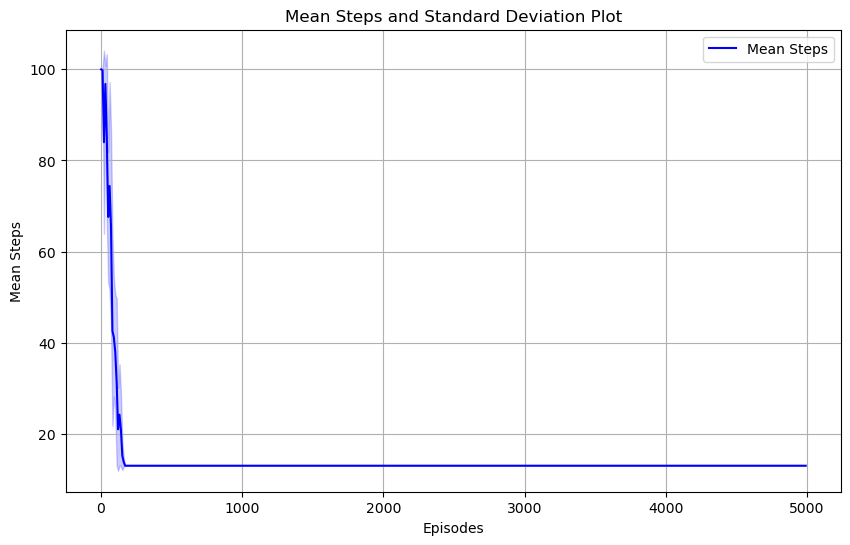

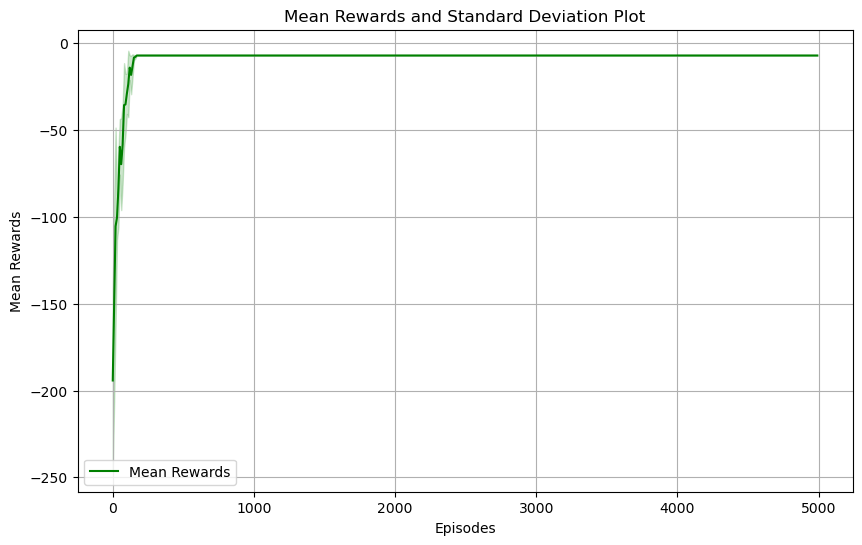

In [33]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


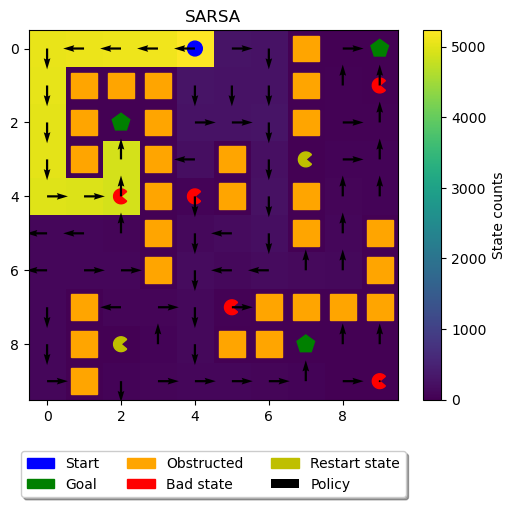

In [34]:



plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


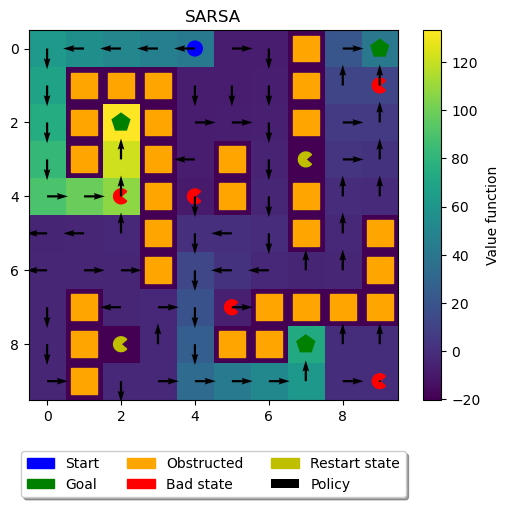

In [35]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")